### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm 
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [2]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/Self Case Study 2")   

Model 1 was an enocoder- decoder model. where enocder is used to extract the image features and decoder is used to generate the corresponding medical report.

Here we extract the image features using CheXNet model itself.
Now,instead of giving this features directly to the decoder model we perform some attention mechanism on the image features. Now, to the decoder, we give the context vector we obtained after attention which contains the relative importance of image regions. So based on this context vector the decoder generate the most apppropriate word.

## CheXnet Model

In model 1 the output required from the chexnet model was a flattened vector of sie 1048. So we used pooling ="avg". This will create a global average pooling layer as the final layer. Here we need the tensor without flattening. So we do not use global average pooling. So the final output (before softmax) we get will be of size 7,7,1024

In [4]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape)
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

chexnet_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

We have loaded the pre-trained chexnet model. Now we don't need the whole model. So we remove the last layer, and we take the output from the second last layer and consider it as the image features

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")   

### Read the data containing image paths and reports

In [6]:
#first we split the data set into train and test data sets
train=pd.read_csv("train")
test=pd.read_csv("test") 

In [7]:
train=train.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1)
train.head()

,patient_id,image1,image2,report
0,CXR2245_IM-0842,NLMCXR_png/CXR2245_IM-0842-1001.png,NLMCXR_png/CXR2245_IM-0842-2001.png,cardiomediastinal silhouettes are within norma...
1,CXR2622_IM-1110,NLMCXR_png/CXR2622_IM-1110-1001.png,NLMCXR_png/CXR2622_IM-1110-1002.png,normal heart size and mediastinal contours. fo...
2,CXR2144_IM-0765,NLMCXR_png/CXR2144_IM-0765-1001.png,NLMCXR_png/CXR2144_IM-0765-2001.png,stable calcified hilar and granulomas. lungs a...
3,CXR3871_IM-1964,NLMCXR_png/CXR3871_IM-1964-1001.png,NLMCXR_png/CXR3871_IM-1964-2001.png,comparison chest . well expanded and clear lun...
4,CXR825_IM-2355,NLMCXR_png/CXR825_IM-2355-1001.png,NLMCXR_png/CXR825_IM-2355-2001.png,patchy bilateral airspace disease with pulmona...


In [8]:
leng=[]
for rep in train["report"]:
  leng.append(len(rep.split()))

print("90th percentile is ",np.percentile(leng,90))
print("99th percentile is ",np.percentile(leng,99))
print("max length is ",np.max(leng))


90th percentile is  41.0
99th percentile is  64.89999999999964
max length is  135


We will take maxlen accordingly between 70 and 100

In [9]:
'''
Obtaining the image feature for every patient using the final chexnet model which we had build earlier.
Here we pass two images. Now we predict the 7,7,1024 dimensional vector for each image from the final chexnet model.
Now we need to concatenate these features. Here we conatenate these features along the width and then we will get a 7,14,1024 dimensional vector after 
cocatenation. Now to perform the attention mechansm we convert this into (7x14),1024 i.e, 96,1024 dimensional tensor. So there will be 96 regions 
in the image with a depth of 1024.
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_1_out=final_chexnet_model(image_1)
  image_2_out=final_chexnet_model(image_2)
  #conactenate along the width
  conc=np.concatenate((image_1_out,image_2_out),axis=2)
  #reshape into(no.of images passed, length*breadth, depth)
  image_feature=tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))
  

  
  return image_feature

In [10]:
# train_features=np.zeros((3056,98,1024))
# test_features=np.zeros((764,98,1024))

# for row in tqdm(range(train.shape[0])):
#   image_1=train.iloc[row]["image1"]
#   image_2=train.iloc[row]["image2"]
#   train_features[row]=(image_feature_extraction(image_1,image_2))


In [11]:
# for row in tqdm(range(test.shape[0])):
#   image_1=test.iloc[row]["image1"] 
#   image_2=test.iloc[row]["image2"]
#   test_features[row]=(image_feature_extraction(image_1,image_2)) 

In [12]:
# np.save("train_features_attention",train_features)
# np.save("test_features_attention",test_features)

In [13]:
train_features=np.load("train_features_attention.npy")
test_features=np.load("test_features_attention.npy")  

In [38]:
print(train_features.shape)
print(test_features.shape) 

(3056, 98, 1024)
(764, 98, 1024)


In [15]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["report"].values]
train_report_in=["<sos> "+text for text in train["report"].values]
train_report_out=[text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]
test_report_in=["<sos> " +text for text in test["report"].values]
test_report_out=[text+" <eos>" for text in test["report"].values]  

In [16]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])

<sos> cardiomediastinal silhouettes are within normal limits. lungs are clear without focal consolidation pneumothorax pleural effusion. bony thorax unremarkable. 
****************************************************************************************************
cardiomediastinal silhouettes are within normal limits. lungs are clear without focal consolidation pneumothorax pleural effusion. bony thorax unremarkable.  <eos>


In [39]:
bs=10
max_len=80

In [40]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [19]:
# #now we prepare the data set with the image fetaures and the reports
# train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_padded_inp,train_padded_out)).shuffle(500)
# train_dataset = train_dataset.batch(bs, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_padded_inp,test_padded_out)).shuffle(500)
# test_dataset = test_dataset.batch(bs,drop_remainder=True) 


In [41]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 


100%|██████████| 2016/2016 [00:00<00:00, 334376.66it/s]

Done


### Model with attention

1. We extract image features from feature extraction module

2. Now we pass this to encoder model which gives the encoder outputs

3. For the decoder model,


*   First we pass the decoder hidden state and encoder output to the attention model which calculate the attention weights
*   Now using the attention weights and encoder output we calculate the context vector

*   Now we take the context vector and embedding vector of decoder input and conncatenate this to a vector
*   Now we take this concatenated vector and pass it to the gru

*   Then the gru output is passed to the final dense layer








In [21]:
enc_units=64
embedding_dim=300
dec_units=64
att_units=64
 

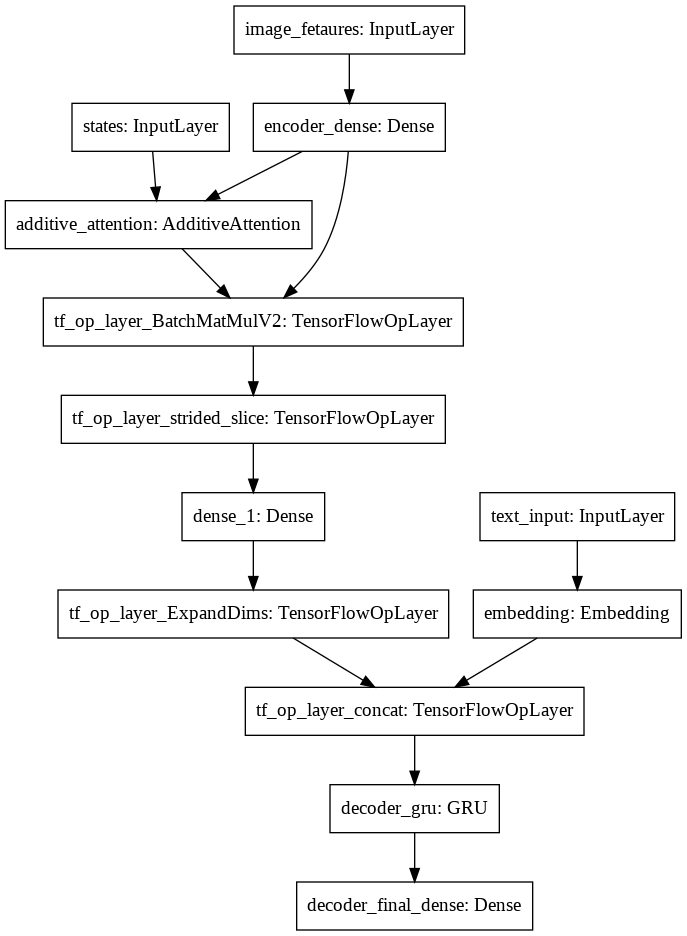

In [22]:
input_img=Input(shape=(98,1024),name="image_fetaures")
input_txt=Input(shape=(max_len),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.5)(en_out)

state_h= Input(shape=(bs,enc_units),name="states")
#decoder model with attention

emb_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_b=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),emb_out],axis=1)
gru_out,state=tf.keras.layers.GRU(dec_units,return_sequences=True,return_state=True,name="decoder_gru")(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense") (gru_out)
en_de=Model(inputs=[input_txt,input_img,state_h],outputs=out)

keras.utils.plot_model(en_de)

In [23]:
#encoder model
'''
here the input will be image features with size (96,1024). We can consider this tensor as the encoder output.
But here we add another dense layer that will reduce the depth of this feature from 1024 to a low value
'''

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state
      If batch size is 32- Hidden state shape is [32,units]
      '''
      hidden=tf.zeros((batch_size,self.units))
      
      return hidden 


In [24]:
'''
this is the attention class. 
Here the input to the decoder and the gru hidden state at the pevious time step are given, and the context vector is calculated

This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model

Here conact function is used for calaculating the attention weights

'''

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    
    # print(x.shape)
    # print(encoder_output.shape)
      
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)

    # print("en",encoder_output.shape)
    # print("al",alphas.shape)
    
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
    # context_vector = alphas*encoder_output
    # print("c",context_vector.shape)


    return (context_vector,alphas)
        
        
    
    

In [25]:
'''
This class will perform the decoder task.
The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput 
at time step t.
This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model

'''

class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
  #def build(self,inp_shape):
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

    self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 


  def call(self,input_to_decoder, encoder_output, state_h):
    
    embed=self.embedding(input_to_decoder)
    
    context_vector,alpha=self.attention(state_h,encoder_output)
    
    context_vector=self.dense_2(context_vector) 
    
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,decoder_state_1=self.gru(result,initial_state=state_h)
    out=tf.reshape(output,(-1,output.shape[-1]))

    out=tf.keras.layers.Dropout(0.5)(out)
    
    dense_op=self.dense(out)
    
    return dense_op,decoder_state_1,alpha

In [26]:
'''
For every input sentence, each output word is generated using one step decoder. Each output word is stored using the final decoder model and the
final output sentence is returned

'''

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
    

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
        
  
    #Coompute the image features using feature extraction model and pass it to the encoder
    # This will give encoder ouput
   # Pass the decoder sequence,encoder_output,initial states to Decoder
    # return the decoder output

  
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h)
      
        return output

    
      

In [29]:


model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)


In [30]:

optimizer = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_ 

In [32]:


model.compile(optimizer=optimizer,loss=custom_lossfunction)


In [ ]:
red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2, min_lr=0.0001)
ckpt=tf.keras.callbacks.ModelCheckpoint("model2wts/ckpt",monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto')

In [ ]:
model.fit([train_features[:3050],train_padded_inp[:3050]],train_padded_out[:3050],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]),
          batch_size=bs,epochs=15,callbacks=[red_lr,ckpt]) 

Epoch 1/15
305/305 [==============================] - 51s 167ms/step - loss: 0.8901 - val_loss: 0.6308
Epoch 2/15
305/305 [==============================] - 37s 120ms/step - loss: 0.6217 - val_loss: 0.5646
Epoch 3/15
305/305 [==============================] - 37s 120ms/step - loss: 0.5574 - val_loss: 0.5036
Epoch 4/15
305/305 [==============================] - 36s 119ms/step - loss: 0.5085 - val_loss: 0.4595
Epoch 5/15
305/305 [==============================] - 36s 119ms/step - loss: 0.4736 - val_loss: 0.4268
Epoch 6/15
305/305 [==============================] - 37s 120ms/step - loss: 0.4463 - val_loss: 0.4018
Epoch 7/15
305/305 [==============================] - 37s 120ms/step - loss: 0.4244 - val_loss: 0.3806
Epoch 8/15
305/305 [==============================] - 36s 119ms/step - loss: 0.4059 - val_loss: 0.3637
Epoch 9/15
305/305 [==============================] - 36s 119ms/step - loss: 0.3875 - val_loss: 0.3502
Epoch 10/15
305/305 [==============================] - 37s 120ms/step - l

In [33]:
model.load_weights("model2wts/beam_fit_15_b") 

In [34]:
def take_second(elem):
    return elem[1]

In [35]:
import time

**PREDICTION USING BEAM SEARCH**

In [36]:

def beam_search(image1,image2, beam_index):

    hidden_state =  tf.zeros((1, enc_units))

    image_features=image_feature_extraction(image1,image2)

    encoder_out = model.layers[0](image_features)

    start_token = [token.word_index["<sos>"]]
    dec_word = [[start_token, 0.0]]
    while len(dec_word[0][0]) < max_len:
        temp = []
        for word in dec_word:
            
            predict, hidden_state,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state)
           
           
            word_predict = np.argsort(predict[0])[-beam_index:]
            for i in word_predict:

                next_word, probab = word[0][:], word[1]
                next_word.append(i)
                probab += predict[0][i] 
                temp.append([next_word, probab.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        
        
        dec_word = sorted(dec_word, key=take_second)
       
        # Getting the top words
        dec_word = dec_word[-beam_index:] 
        
     
    final = dec_word[-1]
    
    report =final[0]
    score = final[1]
    temp = []
    
    for word in report:
      if word!=0:
        if word != token.word_index['<eos>']:
            temp.append(token.index_word[word])
        else:
            break 

    rep = ' '.join(e for e in temp)        
    
    return rep, score

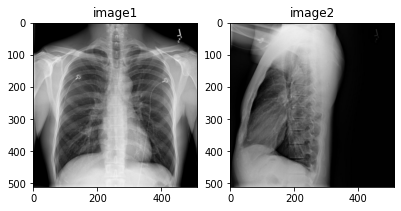

ACTUAL REPORT:  <sos> the heart normal size and contour. the lungs are clear without evidence infiltrate. there pneumothorax effusion.  <eos>
GENERATED REPORT:  <sos> heart size within normal limits. there pleural effusion.
BLEU SCORE IS:  0.7536324264832723
time required for the evaluation is  3.545520544052124


In [ ]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start) 

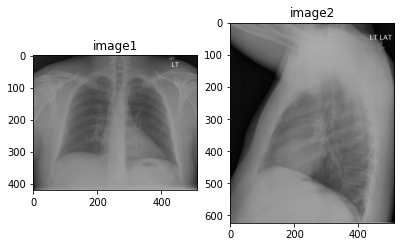

ACTUAL REPORT:  <sos> heart and mediastinum within normal limits. negative for focal pulmonary consolidation pleural effusion pneumothorax.  <eos>
GENERATED REPORT:  <sos> heart size within normal limits. there pneumothorax pleural effusion pneumothorax pleural effusion.
BLEU SCORE IS:  0.6606328636027614
time required for the evaluation is  3.3450400829315186


In [ ]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start)     


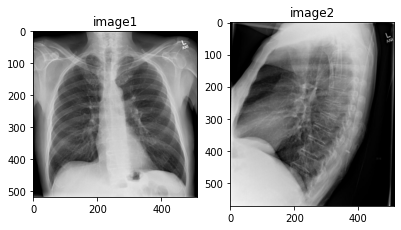

ACTUAL REPORT:  <sos> the lungs are clear. there pleural effusion pneumothorax. the heart and mediastinum are normal. the skeletal structures are normal.  <eos>
GENERATED REPORT:  <sos> heart size within normal limits. lungs are clear. there pleural effusion.
BLEU SCORE IS:  0.7093339167321887
time required for the evaluation is  2.8039751052856445


In [80]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i] 
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result) 
end=time.time()
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
print("time required for the evaluation is ",end-start) 


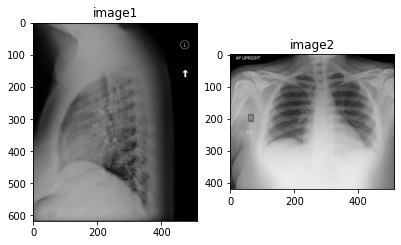

ACTUAL REPORT:  <sos> there are low lung volumes. the lungs are otherwise clear. focal airspace consolidation pleural effusion. calcific density the right lung apex compatible with calcified granuloma.  <eos>
GENERATED REPORT:  <sos> heart size within normal limits. there pneumothorax pleural effusion pneumothorax.
BLEU SCORE IS:  0.6904573083274563
time required for the evaluation is  3.319004774093628


In [ ]:
import random 
start=time.time()
i=100
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start) 

**OBSERVATION FROM THE ABOVE PREDICTION**

Here the actual report was saying about lungs. But the predicted report is about heart. Also other important terms like focal airsace consoidation, cacific density etc are not there in predicted report.

The structure of the sentence is also not very good

In [ ]:
#compute average bleu score for test data
index=range(0,test.shape[0])
start=time.time()
bl=0
for i in (index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result,sore=beam_search(img1,img2,3) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)
end=time.time()
print("\n")
print("average bleu score on the test data is ",bl/test.shape[0])




average bleu score on the test data is  0.7181150122958847


In [ ]:
print("the average time for evaluating the attention model with beam search is ", (end-start)/764,"seconds")

the average time for evaluating the attention model with beam search is 3.2034 seconds


**OBSERVATIONS:** This model  gave good results as compared to the baseline model



In this approach we used attention mechansim and the prediction of the reports was done using the beam search algorithm. We can see that the results are improved a lot as compared to the previous models.

We can see that if the x-ray and actual report contains important parts like heart,lungs, left lobe,contours, spine etc they are recalled well in the generated report also

The bleu score has also got better

The time taken for evaluation is higher as compared to other models. This is because

1. We increased the number of parameters through attention

2. We used beam search

But we don't have strict latency constraints. So 5 to 15 seconds time for evaluation is not a big problem

**LIMITATIONS**
 
Some of the generated sentences are not meaningful. The sentence structure needs to be improved. 

Also some most frequent words like lungs, heart, etc are appearing in all the sentences. 